In [1]:
import os
import sys
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import n2j.inference.infer_utils as iutils
from n2j.inference.inference_manager import InferenceManager
from n2j.config_utils import get_config_modular

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Hierarchical inference for Validation

__Author:__ Ji Won Park (@jiwoncpark)

__Created:__ 7/10/2021 

__Last run:__ 8/18/2021

__Goal__: Using the BNN-generated $\kappa$ posteriors, we 
1. infer the population-level distribution in $\kappa$ using importance sampling and 
2. use this information to reweight the individual BNN posteriors so that the interim (training) prior is divided out and the new, inferred test prior reapplied.

__Before running:__
From the repo root, run
```
python infer.py <path to config file>
```

Let's read in the config file, which contains various configs used in training and to be used in inference.

In [2]:
# Paste the path to the config file in the list
cfg = get_config_modular(['../tuning_configs_local_val/nersc_config_T8.yml'])

We then instantiate the `InferenceManager` and load the training dataset.

In [3]:
infer_obj = InferenceManager(checkpoint_dir=cfg['trainer']['checkpoint_dir'],
                                 **cfg['inference_manager'])
# Load training stats (for normalizing data)
norm_obj = getattr(stats, cfg['data']['train_dist_name'])(**cfg['data']['train_dist_kwargs'])
train_raytracing = [os.path.join(cfg['data']['in_dir'],
                                 f'cosmodc2_{hp}/Y_{hp}') for hp in cfg['data']['train_hp']]
infer_obj.load_dataset(
                       dict(features=cfg['data']['features'],
                            raytracing_out_dirs=train_raytracing,
                            healpixes=cfg['data']['train_hp'],
                            n_data=cfg['data']['n_train'],
                            aperture_size=1.0,
                            subsample_pdf_func=norm_obj.pdf,
                            n_subsample=cfg['data']['n_subsample_train'],
                            stop_mean_std_early=False,
                            in_dir=cfg['data']['in_dir']),
                       sub_features=cfg['data']['sub_features'],
                       sub_target=cfg['data']['sub_target'],
                       sub_target_local=cfg['data']['sub_target_local'],
                       is_train=True,
                       batch_size=cfg['data']['batch_size'],
                       num_workers=cfg['data']['num_workers'],
                       rebin=False,
                       noise_kwargs=cfg['data']['noise_kwargs']
                       )

Mag errors added to ['u', 'g', 'r', 'i', 'z', 'y']
Train dataset size: 100000


Next, let's load the test set, subsampling so that the test sightlines follow a narrow normal as defined by the config file.

In [4]:
norm_obj_test = getattr(stats, cfg['test_data']['dist_name'])(**cfg['test_data']['dist_kwargs'])
test_raytracing = [os.path.join(cfg['data']['in_dir'],
                                f'cosmodc2_{hp}/Y_{hp}') for hp in cfg['test_data']['test_hp']]
infer_obj.load_dataset(dict(features=cfg['data']['features'],
                            raytracing_out_dirs=test_raytracing,
                            healpixes=cfg['test_data']['test_hp'],
                            n_data=cfg['test_data']['n_test'],
                            aperture_size=1.0,
                            subsample_pdf_func=norm_obj_test.pdf,
                            n_subsample=cfg['test_data']['n_subsample_test'],
                            in_dir=cfg['data']['in_dir']),
                       sub_features=cfg['data']['sub_features'],
                       sub_target=cfg['data']['sub_target'],
                       sub_target_local=cfg['data']['sub_target_local'],
                       is_train=False,
                       batch_size=cfg['test_data']['batch_size'],
                       noise_kwargs=cfg['data']['noise_kwargs']
                       )

Test dataset size: 100


We have a broad training prior and a narrow, overdense (high-$\kappa$) test distribution.

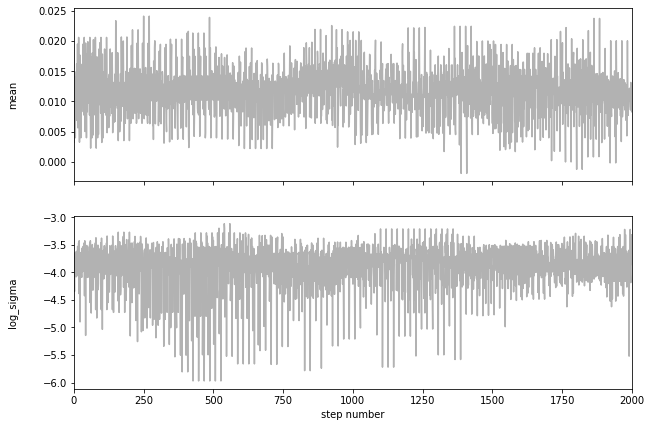

In [5]:
# Path to the stored MCMC chain
chain_path = os.path.join(infer_obj.out_dir, 'omega_chain.h5')
mcmc_samples = iutils.get_mcmc_samples(chain_path, 
                                       chain_kwargs=dict(flat=True, discard=100))
iutils.get_chain_plot(mcmc_samples, None)

Reading existing `k_bnn_reweighted.npy`...
(100000,) (100,) (100, 1, 20000) (100, 1, 1000)


NameError: name 'grid' is not defined

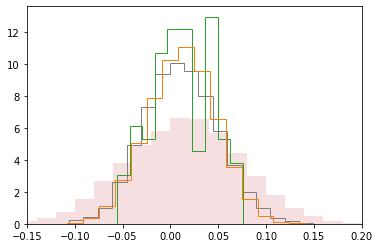

In [6]:
# Interim prior samples
train_k = infer_obj.get_true_kappa(is_train=True).squeeze()
# Test samples
test_k = infer_obj.get_true_kappa(is_train=False).squeeze()
# Raw BNN samples
k_bnn = infer_obj.get_bnn_kappa()
# Reweighted BNN samples
k_bnn_reweighted = infer_obj.get_reweighted_bnn_kappa(None, None)
print(train_k.shape, test_k.shape, k_bnn.shape, k_bnn_reweighted.shape)

plt.close('all')
_, bins, _ = plt.hist(train_k, bins=20, density=True, color='tab:gray', 
                      label='train', histtype='step')
_ = plt.hist(test_k, bins=10, density=True, color='tab:green', 
             label='test', histtype='step')
_ = plt.hist(k_bnn.reshape(-1), bins=20, density=True, color='tab:orange', 
             label='stacked BNN samples', histtype='step')
_ = plt.hist(k_bnn_reweighted.reshape(-1), bins=20, density=True, color='#d6616b', alpha=0.2,
             label='stacked BNN samples, reweighted')

plt.xlim([-0.15, 0.2])
plt.plot(grid, norm_obj.pdf(grid), color='k')
plt.plot(grid, norm_obj_test.pdf(grid), color='k', label='input normal PDF')
plt.legend(loc='upper left')
plt.xlabel('$\kappa$')
plt.ylabel('Density')

(100, 1, 20000)


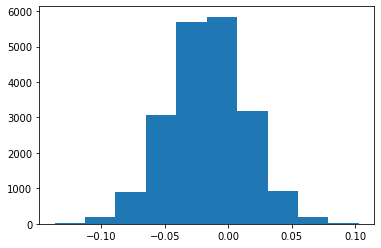

In [7]:
k_bnn = infer_obj.get_bnn_kappa()
print(k_bnn.shape)
_ = plt.hist(k_bnn[0, 0, :])

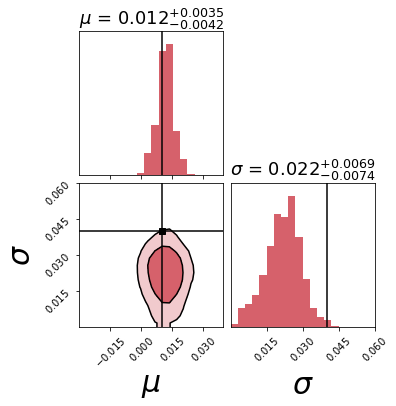

In [8]:
infer_obj.visualize_omega_post(log_idx=1,
                               chain_path=chain_path,
                               corner_kwargs=dict(
                                                 range=[[-0.03, 0.04], [0, 0.06]],
                                                 color='#d6616b',
                                                 smooth=1.0,
                                                 alpha=1.0,
                                                 truths=np.array([0.01, 0.04]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".2g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=100
                                                 ))

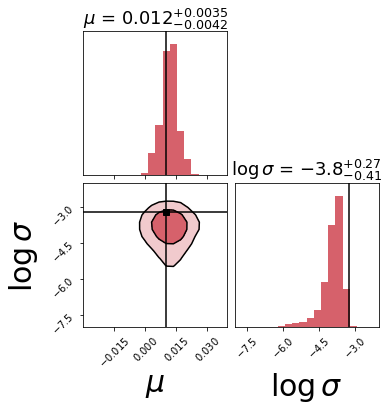

In [9]:
infer_obj.visualize_omega_post(log_idx=None,
                               chain_path=chain_path,
                               corner_kwargs=dict(
                                                 range=[[-0.03, 0.04], [-8, -2]],
                                                 color='#d6616b',
                                                 smooth=1,
                                                 alpha=1.0,
                                                 truths=np.array([0.01, np.log(0.04)]),
                                                 label_kwargs={'fontsize': 30},
                                                 labels=[r'$\mu$', r'$\log \sigma$'],
                                                 fill_contours=True,
                                                 plot_datapoints=False,
                                                 plot_contours=True,
                                                 show_titles=True,
                                                 levels=[0.68, 0.95],
                                                 truth_color='k',
                                                 contour_kwargs=dict(linestyles='solid', colors='k'),
                                      #contourf_kwargs=dict(colors='#843c39'),
                                                 quiet=True,
                                                 #quantiles=[0.5 - 0.34, 0.5 + 0.34],
                                                 title_fmt=".2g",
                                                 fig=None,
                                                 title_kwargs={'fontsize': 18},
                                                 #range=[0.99]*len(cols_to_plot),
                                                 use_math_text=True,
                                                 hist_kwargs=dict(density=True, 
                                                                  histtype='stepfilled',))
                                                 ,
                               chain_kwargs=dict(
                                                 flat=True,
                                                 thin=1,
                                                 discard=100
                                                 ))

Reading existing `k_bnn_reweighted.npy`...
Reading existing `k_bnn_reweighted.npy`...


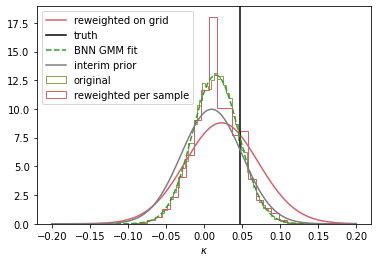

In [10]:
idx = 5
reweighted_k_bnn = infer_obj.get_reweighted_bnn_kappa(None, None)
infer_obj.visualize_kappa_post(idx=idx, n_samples=50, n_mc_dropout=20,
                               interim_pdf_func=norm_obj.pdf,
                               )
grid, log_w = infer_obj.get_kappa_log_weights_grid(idx)
bnn_gmm_fit = np.load(os.path.join(infer_obj.out_dir, f'grid_bnn_gmm_{idx}.npy'))
plt.plot(grid, bnn_gmm_fit, label='BNN GMM fit', color='tab:green', linestyle='--')
#plt.plot(grid, 
#         9*np.exp(log_w),
#         color='#d6616b', label='reweighted analytic')
plt.plot(grid, norm_obj.pdf(grid), 
         color='tab:gray', label='interim prior')

plt.legend()

In [14]:
pre_metrics = infer_obj.pre_reweighting_metrics
post_metrics = infer_obj.post_reweighting_metrics

Text(0.5, 1.0, 'Pre-reweighting')

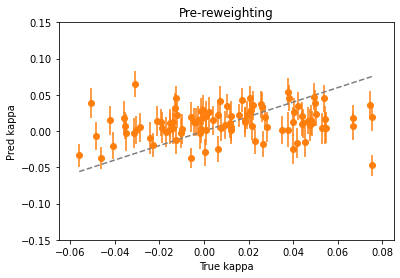

In [15]:
n_test = len(infer_obj.test_dataset)
min_p, max_p = np.min(k_test), np.max(k_test)

plt.errorbar(k_test, pre_metrics['med'].values[:n_test], 
             yerr=pre_metrics['mad'].values[:n_test], fmt='o', color='tab:orange')
plt.plot(np.linspace(min_p, max_p, 20), np.linspace(min_p, max_p, 20), 
         color='tab:gray', linestyle='--', label='1-1')
plt.ylim([-0.15, 0.15])
plt.xlim([-0.065, 0.085])
plt.xlabel('True kappa')
plt.ylabel('Pred kappa')
plt.title('Pre-reweighting')

Text(0.5, 1.0, 'Post-reweighting')

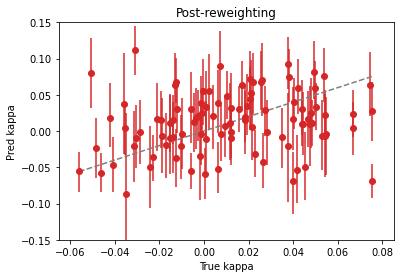

In [16]:
n_test = len(infer_obj.test_dataset)
min_p, max_p = np.min(k_test), np.max(k_test)

plt.errorbar(k_test, post_metrics['med'].values[:n_test],
             yerr=np.stack([post_metrics['minus_sig'].values[:n_test], 
                            post_metrics['plus_sig'].values[:n_test]], axis=0),
             fmt='o', color='tab:red')
plt.plot(np.linspace(min_p, max_p, 20), np.linspace(min_p, max_p, 20), 
         color='tab:gray', linestyle='--', label='1-1')
plt.ylim([-0.15, 0.15])
plt.xlim([-0.065, 0.085])
plt.xlabel('True kappa')
plt.ylabel('Pred kappa')
plt.title('Post-reweighting')

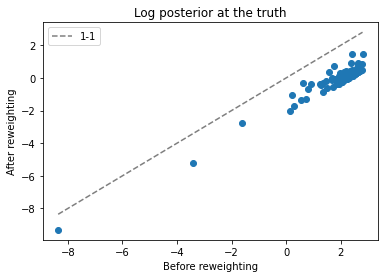

In [17]:
plt.close('all')
min_p, max_p = np.min(pre_metrics['log_p'].values[:n_test]), np.max(pre_metrics['log_p'].values[:n_test])
plt.scatter(pre_metrics['log_p'].values[:n_test], 
            post_metrics['log_p'].values[:n_test])
plt.plot(np.linspace(min_p, max_p, 20), np.linspace(min_p, max_p, 20), 
         color='tab:gray', linestyle='--', label='1-1')
plt.title('Log posterior at the truth')
plt.xlabel('Before reweighting')
plt.ylabel('After reweighting')
plt.legend()

Reading existing `k_bnn_reweighted.npy`...


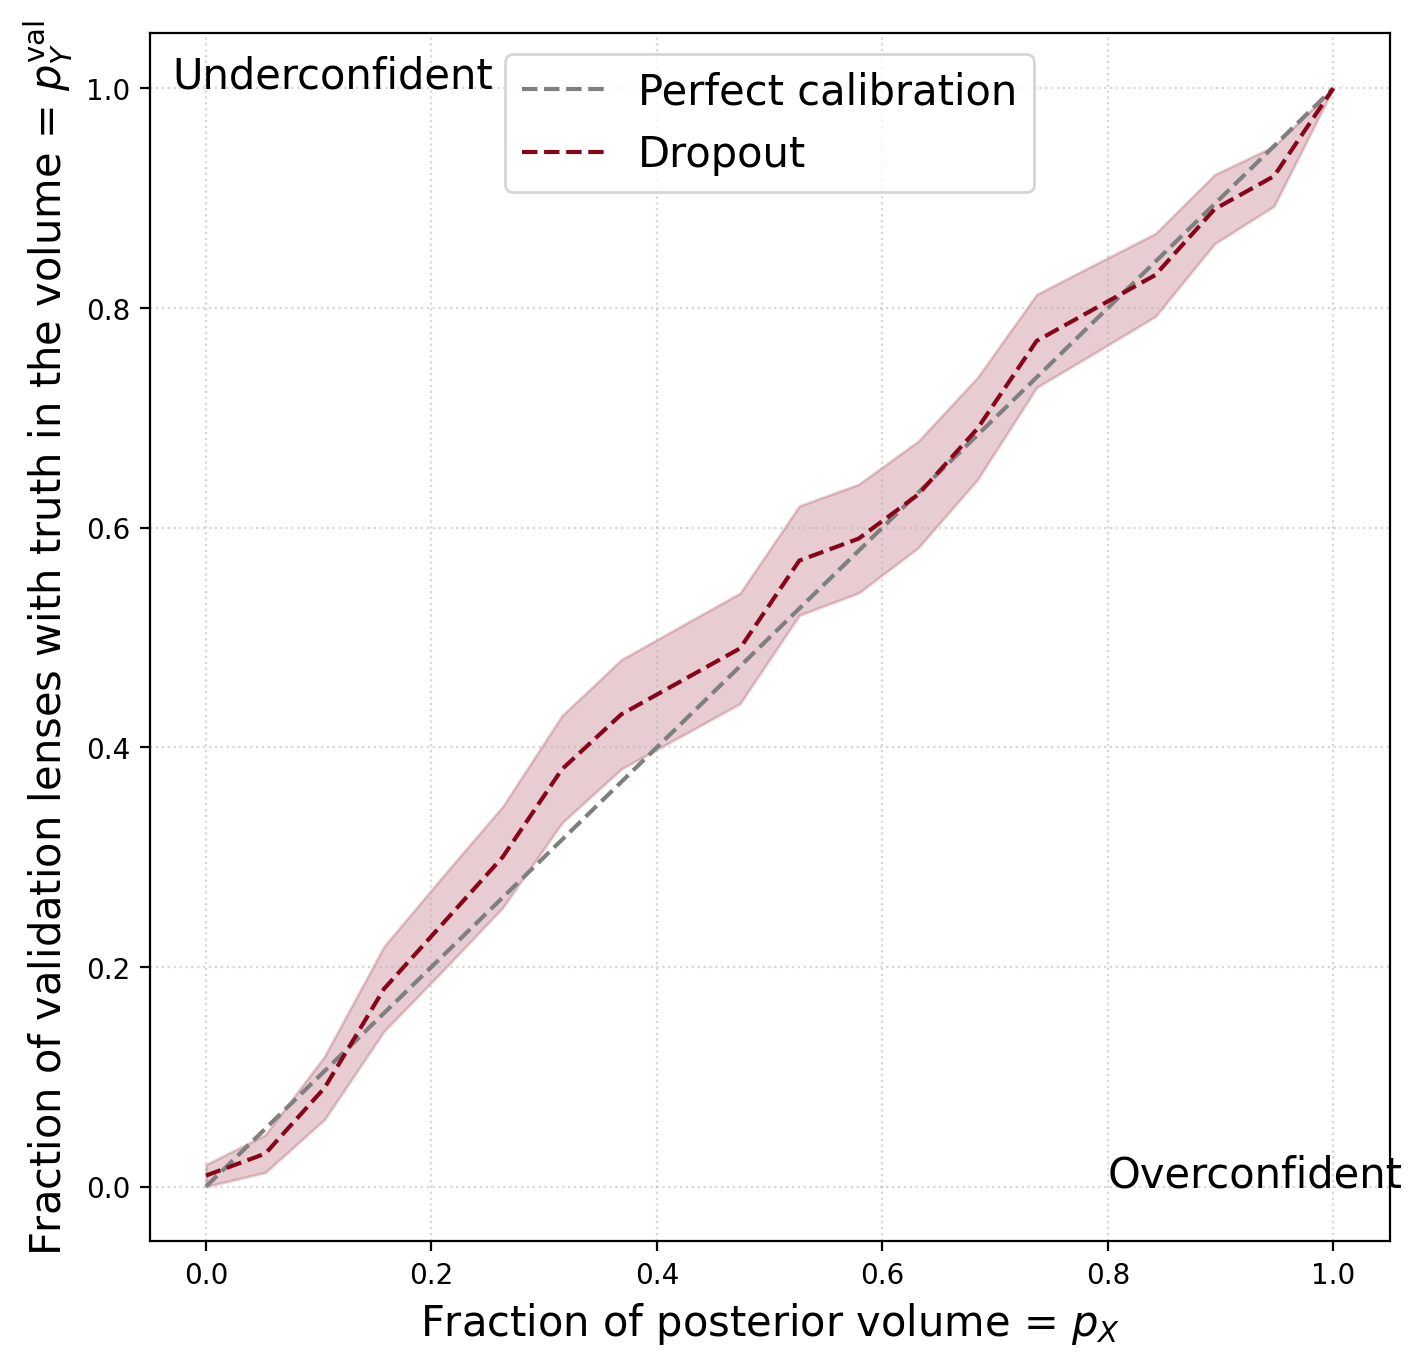

In [18]:
k_bnn_reweighted = infer_obj.get_reweighted_bnn_kappa(1000, None)
infer_obj.get_calibration_plot(k_bnn_reweighted)